# Predict the survival of the patients



**Objective**: 
Develop and optimize 3 machine learning models (logistic regression, decision tree and random forest) to predict the survival of each patient,interpret and compare the fine-tuned models.

# Importing required libraries

In [1]:
import pandas as pd 
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,f1_score
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time

## Load the data

In [2]:
filename = 'ICU.csv'                     # Name of the CSV file
data = pd.read_csv(filename)             # Reading the CSV file as DataFrame

### Convert to Sqlite3 table

In [3]:
# strip whitespace from headers
data.columns = data.columns.str.strip()

con = sql.connect("ICU.db")

# drop data into database
data.to_sql("patients", con, if_exists='replace')

con.close()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


## Data Exploration

### Analysing data

In [4]:
conn = sql.connect("ICU.db")
data = pd.read_sql('SELECT * FROM patients', conn)
# printing the number of records and number of columns in the data by using shape method of dataframe
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")

There are 200 rows and 11 columns.


In [5]:
### print the all column names from the data by using for loop
for col in data.columns:
    print(col)

index
Unnamed: 0
ID
Survive
Age
AgeGroup
Sex
Infection
SysBP
Pulse
Emergency


### samples of datasets


In [6]:
data.head()

,index,Unnamed: 0,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,0,1,4,0,87,3,1,1,80,96,1
1,1,2,8,1,27,1,1,1,142,88,1
2,2,3,12,1,59,2,0,0,112,80,1
3,3,4,14,1,77,3,0,0,100,70,0
4,4,5,27,0,76,3,1,1,128,90,1


In [7]:
data.tail()

,index,Unnamed: 0,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
195,195,196,921,0,50,2,1,0,256,64,1
196,196,197,923,1,20,1,0,0,104,83,1
197,197,198,924,1,73,3,1,0,162,100,1
198,198,199,925,1,59,2,0,0,100,88,1
199,199,200,929,1,42,1,0,0,122,84,1


### Datatypes and Null values


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   index       200 non-null    int64
 1   Unnamed: 0  200 non-null    int64
 2   ID          200 non-null    int64
 3   Survive     200 non-null    int64
 4   Age         200 non-null    int64
 5   AgeGroup    200 non-null    int64
 6   Sex         200 non-null    int64
 7   Infection   200 non-null    int64
 8   SysBP       200 non-null    int64
 9   Pulse       200 non-null    int64
 10  Emergency   200 non-null    int64
dtypes: int64(11)
memory usage: 17.3 KB


### Summarising the Dataset

In [9]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
index,200.0,99.500,57.879185,0.0,49.75,99.5,149.25,199.0
Unnamed: 0,200.0,100.500,57.879185,1.0,50.75,100.5,150.25,200.0
ID,200.0,444.820,271.916680,4.0,210.25,412.5,671.75,929.0
Survive,200.0,0.800,0.401004,0.0,1.00,1.0,1.00,1.0
Age,200.0,57.545,20.054648,16.0,46.75,63.0,72.00,92.0
AgeGroup,200.0,2.025,0.785788,1.0,1.00,2.0,3.00,3.0
Sex,200.0,0.380,0.486604,0.0,0.00,0.0,1.00,1.0
Infection,200.0,0.420,0.494797,0.0,0.00,0.0,1.00,1.0
SysBP,200.0,132.280,32.952099,36.0,110.00,130.0,150.00,256.0
Pulse,200.0,98.925,26.829620,39.0,80.00,96.0,118.25,192.0


## Data Visulization

## Univariate Analysis

### Use bar charts (count plots) for discrete and categorical data

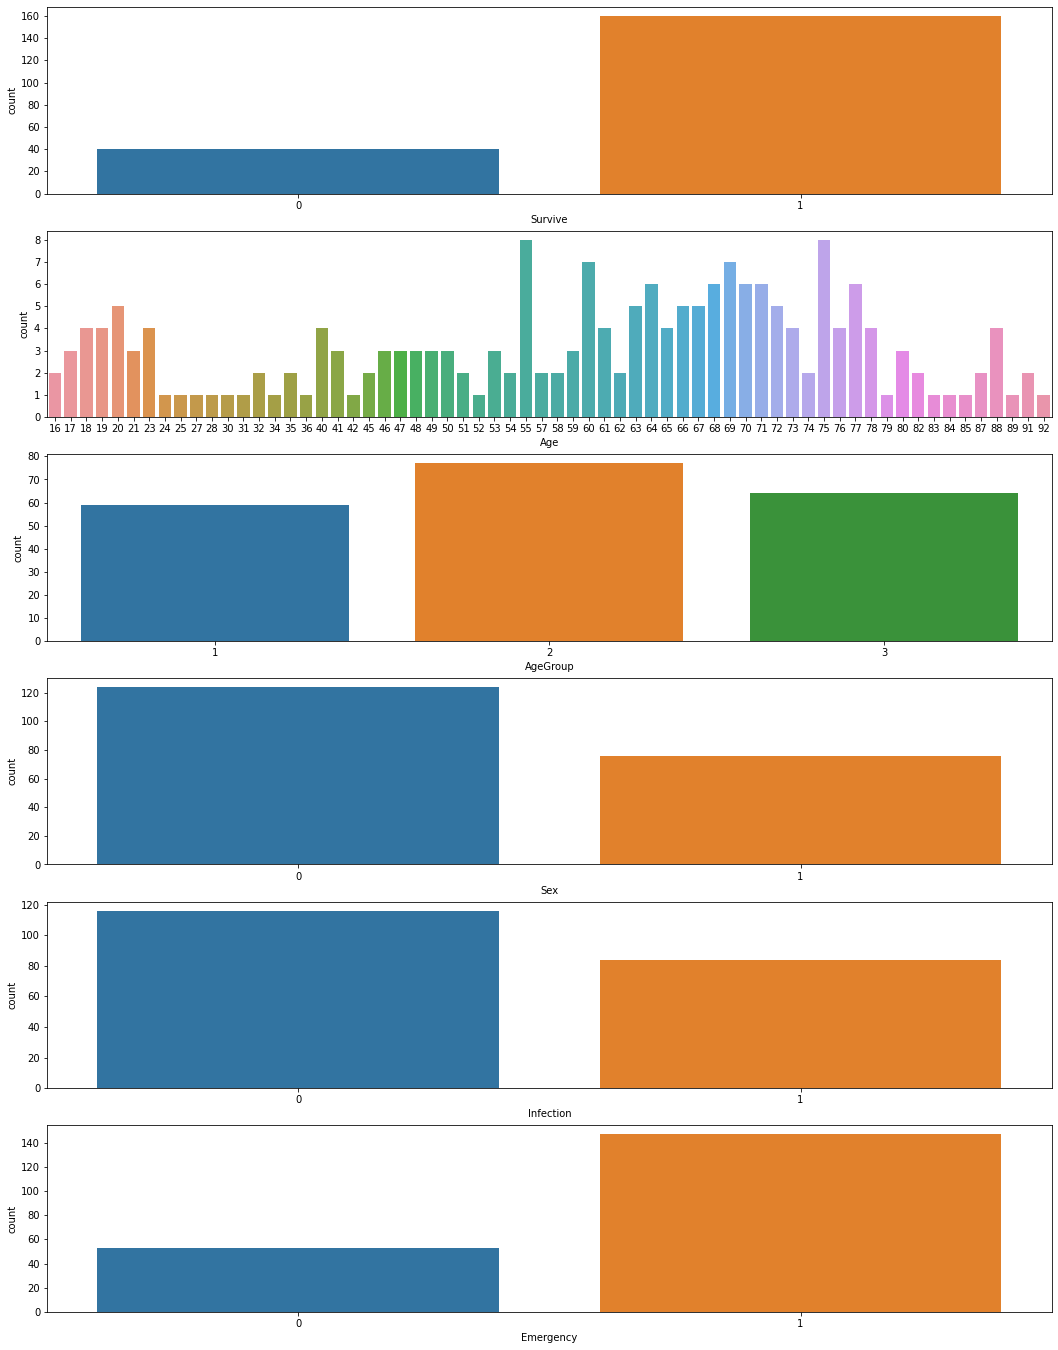

In [10]:
fig, ax = plt.subplots(6,1,figsize=(18,24))
for i, col in enumerate(['Survive', 'Age', 'AgeGroup', 'Sex', 'Infection', 'Emergency']):
    sns.countplot(data= pd.read_sql('SELECT Survive, Age, AgeGroup, Sex, Infection, Emergency FROM patients', conn),
                x=col,
                ax=ax[i])

### Use histograms (hist plots) for continuous data

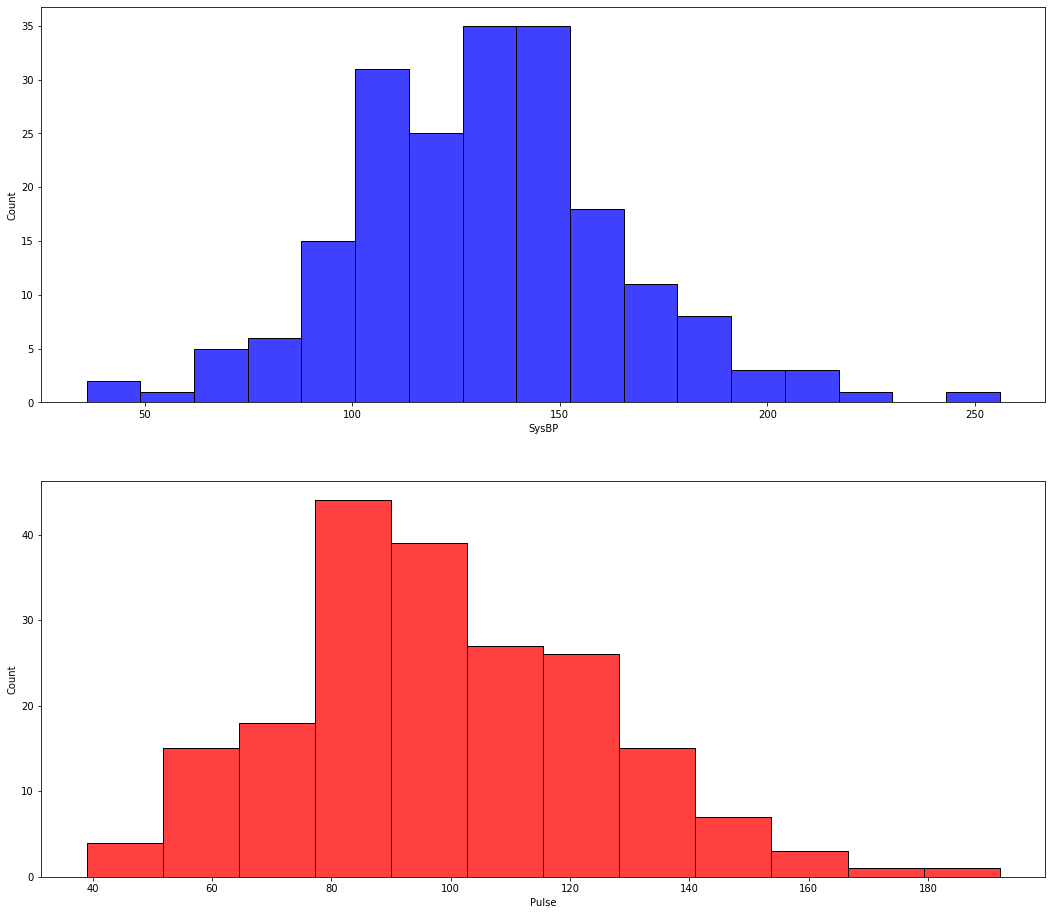

In [11]:
fig, ax = plt.subplots(2,1,figsize=(18,16))
colors=['blue', 'red']
for i, col in enumerate(["SysBP","Pulse"]):
    sns.histplot(data[col],
                ax=ax[i], color=colors[i])

### Bivariate Analysis

### Pairplot

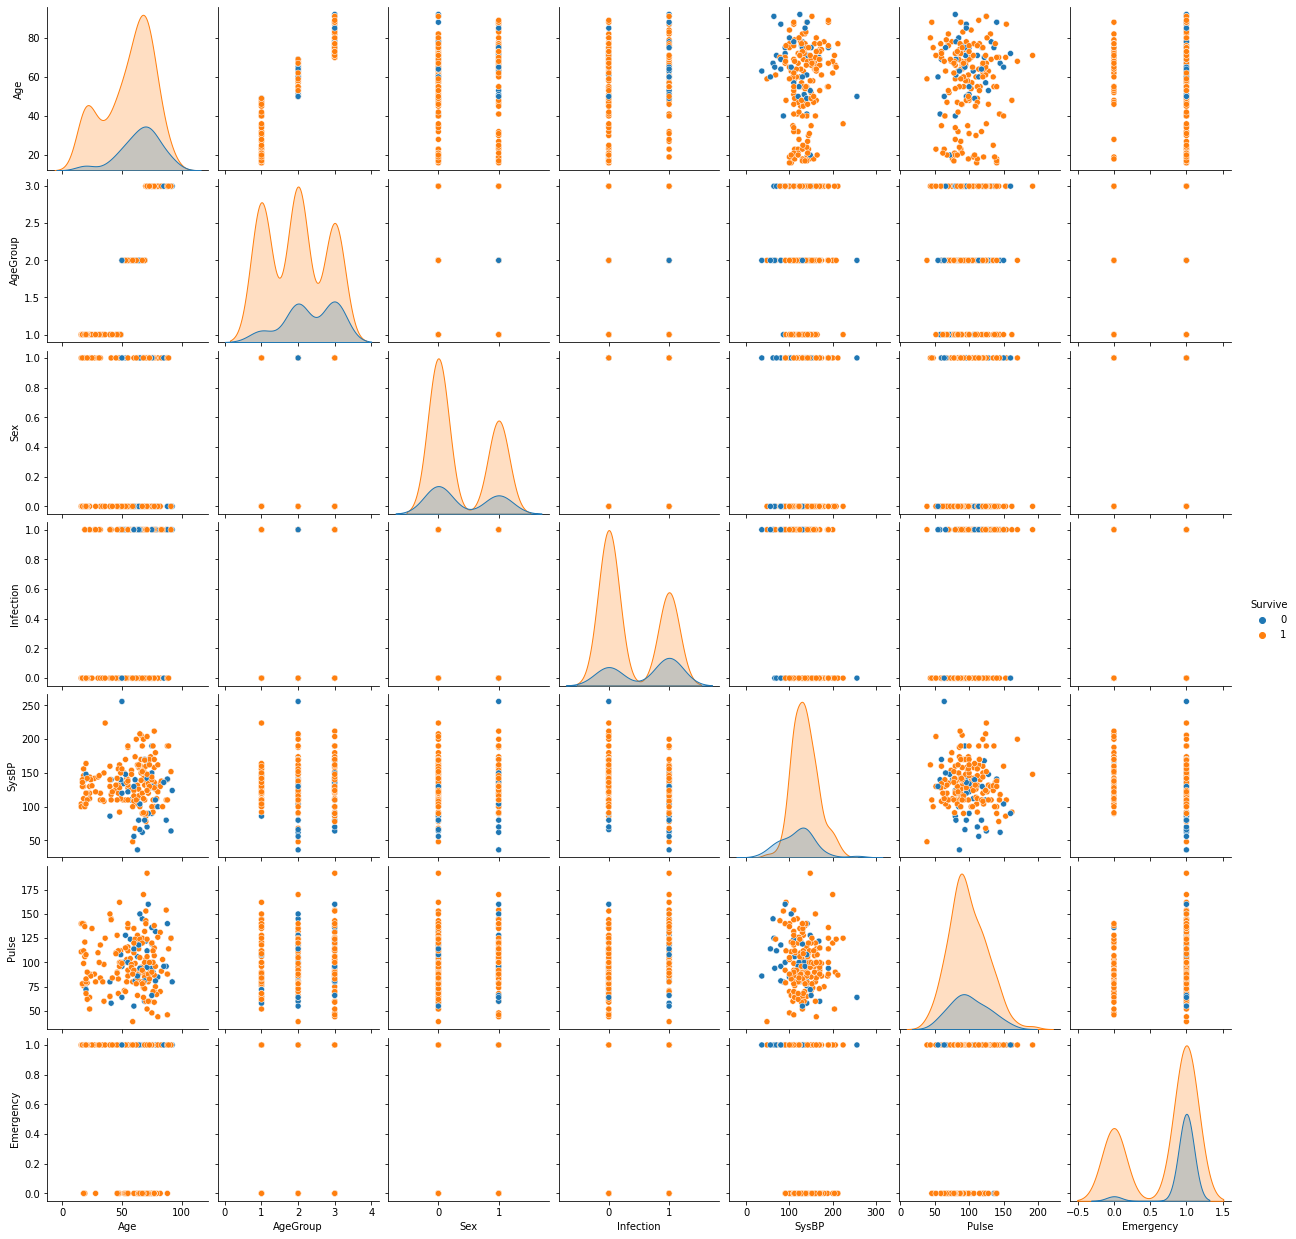

In [12]:
g = sns.pairplot(data.iloc[:,3:], hue="Survive")

### Correlation coefficients between numericals features

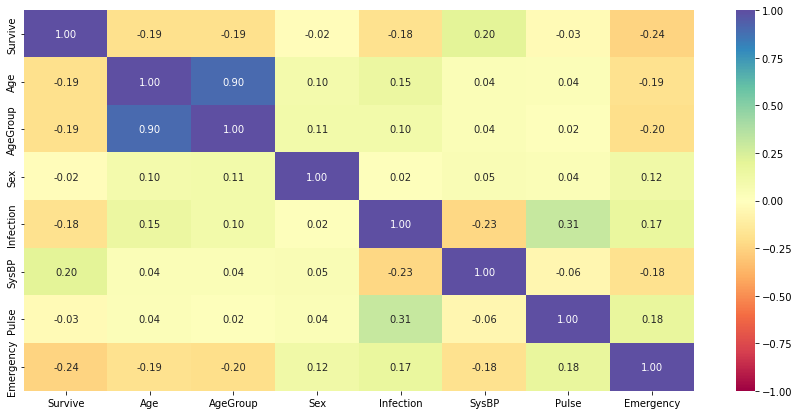

In [13]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    data.iloc[:,3:].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Boxplot

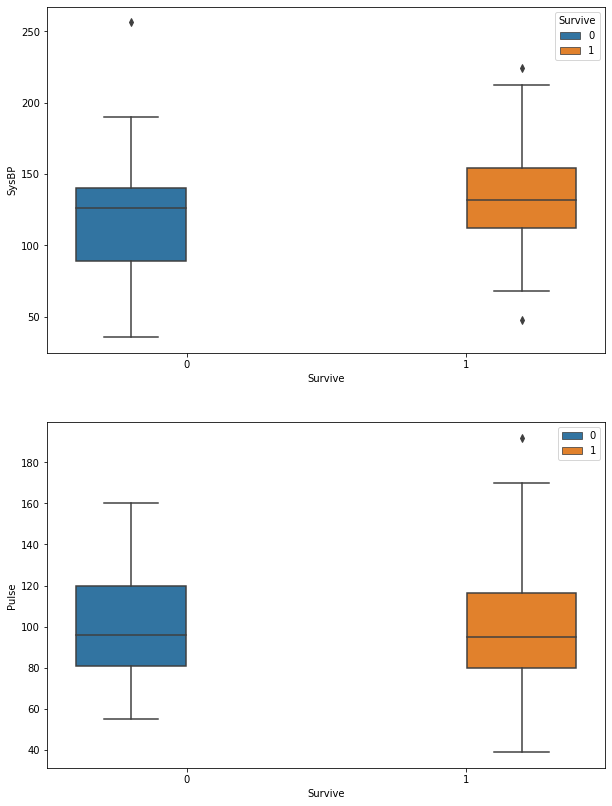

In [14]:
fig, ax = plt.subplots(2,1,figsize=(10,14))
i=0
for col in ["SysBP","Pulse"]:
    sns.boxplot(data=data, y=col, x='Survive', ax=ax[i], hue='Survive')
    i+=1
plt.legend(loc="upper right")
plt.show()

## Data Preprocessing


### Checking for duplicate values

In [15]:
print("size of dataset with duplicates (if any)", data.shape[0])
data = data[data.duplicated() == False]
print("size of dataset without duplicates", data.shape[0])

size of dataset with duplicates (if any) 200
size of dataset without duplicates 200


### Checking for null/missing data

In [16]:
data.isnull().sum()

index         0
Unnamed: 0    0
ID            0
Survive       0
Age           0
AgeGroup      0
Sex           0
Infection     0
SysBP         0
Pulse         0
Emergency     0
dtype: int64

### Outliers

In [17]:
def outlier_detection(col, data):
    # applying the Box Plot Outlier Technique

    q3, q1 = data[col].quantile(0.75), data[col].quantile(0.25)
    print("q3   q1")
    print(q3, q1)

    IQR = q3 - q1

    print("IQR: ",IQR)

    upper_bound = q3 + 1.5 * IQR

    lower_bound = q1 - 1.5 * IQR
    l= data[(data[col]<=lower_bound) | (data[col]>=upper_bound)].shape[0]

    print("Upper Bound: ",upper_bound)

    print("Lower Bound: ", lower_bound)
    print()
    print("Number of Outliers: ", l)
    print("---------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------")

In [18]:
for col in ["SysBP","Pulse"]:
    print("Predictor: ",col)
    print()
    print()
    outlier_detection(col, data)

Predictor:  SysBP


q3   q1
150.0 110.0
IQR:  40.0
Upper Bound:  210.0
Lower Bound:  50.0

Number of Outliers:  5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Predictor:  Pulse


q3   q1
118.25 80.0
IQR:  38.25
Upper Bound:  175.625
Lower Bound:  22.625

Number of Outliers:  1
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------


In [19]:
q3, q1 = data["SysBP"].quantile(0.75), data["SysBP"].quantile(0.25)
print("q3   q1")
print(q3, q1)

IQR = q3 - q1

print("IQR: ",IQR)

upper_bound = q3 + 1.5 * IQR

lower_bound = q1 - 1.5 * IQR
print("shape before outlier removal: ", data.shape)
data = data[(data["SysBP"]>=lower_bound) & (data["SysBP"]<=upper_bound)]
print("shape after outlier removal: ",data.shape)

q3   q1
150.0 110.0
IQR:  40.0
shape before outlier removal:  (200, 11)
shape after outlier removal:  (195, 11)


In [20]:
q3, q1 = data["Pulse"].quantile(0.75), data["Pulse"].quantile(0.25)
print("q3   q1")
print(q3, q1)

IQR = q3 - q1

print("IQR: ",IQR)

upper_bound = q3 + 1.5 * IQR

lower_bound = q1 - 1.5 * IQR
print("shape before outlier removal: ", data.shape)
data = data[(data["Pulse"]>=lower_bound) & (data["Pulse"]<=upper_bound)]
print("shape after outlier removal: ",data.shape)

q3   q1
118.5 80.0
IQR:  38.5
shape before outlier removal:  (195, 11)
shape after outlier removal:  (194, 11)


### Features selection based on EDA


In [21]:
cols= ['Survive', 'AgeGroup', 'Sex', 'Infection','SysBP', 'Pulse', 'Emergency'] # removed Age since it is highly correlated to AgeGroup
df=data[cols]

### Imbalanced data

In [22]:
df['Survive'].value_counts()

1    156
0     38
Name: Survive, dtype: int64

### Data Normalization

In [23]:
cols=['AgeGroup',"SysBP","Pulse"]
for col in cols:
    # divide one by the other
    df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())
df.head()

<ipython-input-23-dc3b502ba2fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())


,Survive,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,0,1.0,1,1,0.157895,0.412698,1
1,1,0.0,1,1,0.565789,0.349206,1
2,1,0.5,0,0,0.368421,0.285714,1
3,1,1.0,0,0,0.289474,0.206349,0
4,0,1.0,1,1,0.473684,0.365079,1


### Train, Test and Split

In [24]:
# splitting data into training and validation set:
X = df.iloc[:,1:]
y = df['Survive']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=39)

print(X_train.shape, X_test.shape)

(135, 6) (59, 6)


### Balancing minority and majority classes in dataset using Smote

In [25]:
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X_train, y_train)

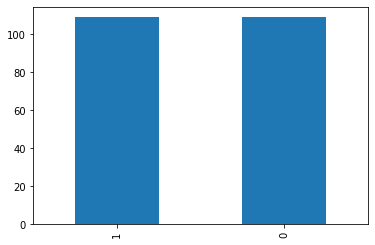

In [26]:
y_smote.value_counts().plot(kind='bar')

In [27]:
# this function is used to plot the confusion matrices for easy comparison
def plot_confusion_matrix(y_test, y_predict):
    C = confusion_matrix(y_test, y_predict)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    A =(((C.T)/(C.sum(axis=1))).T)
    # divid each element of the confusion matrix with the sum of elements in that column
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]         
    # representing A in heatmap format
    cmap=sns.light_palette("cyan")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size": 14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size": 14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size": 14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Training models
Baseline models

Logistic Regression intialized
Training model
Completed model training.
Prediction on test
Model:  Logistic Regression
Classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        47

    accuracy                           0.80        59
   macro avg       0.40      0.50      0.44        59
weighted avg       0.63      0.80      0.71        59



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-27-2a838445d062>:7: RuntimeWarning: invalid value en

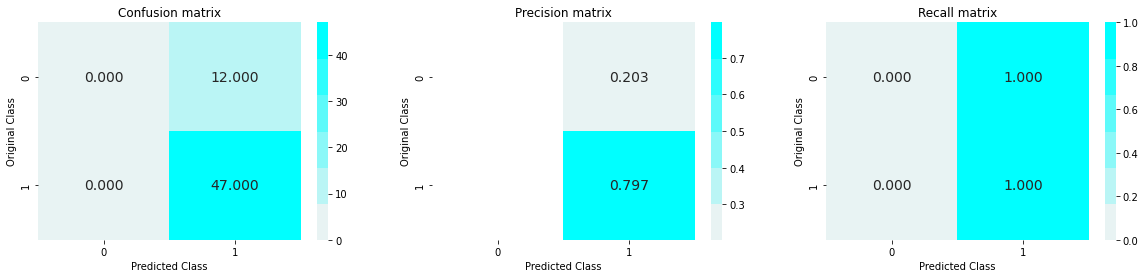



Decision Tree intialized
Training model
Completed model training.
Prediction on test
Model:  Decision Tree
Classification_report
              precision    recall  f1-score   support

           0       0.29      0.17      0.21        12
           1       0.81      0.89      0.85        47

    accuracy                           0.75        59
   macro avg       0.55      0.53      0.53        59
weighted avg       0.70      0.75      0.72        59



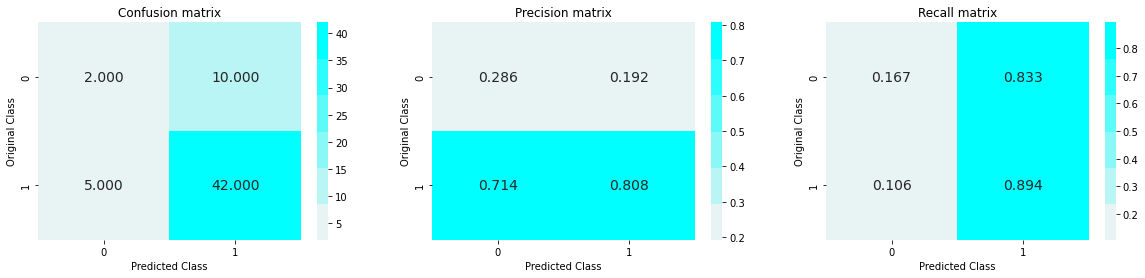



Random Forest intialized
Training model
Completed model training.
Prediction on test
Model:  Random Forest
Classification_report
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.81      1.00      0.90        47

    accuracy                           0.81        59
   macro avg       0.91      0.54      0.52        59
weighted avg       0.85      0.81      0.74        59



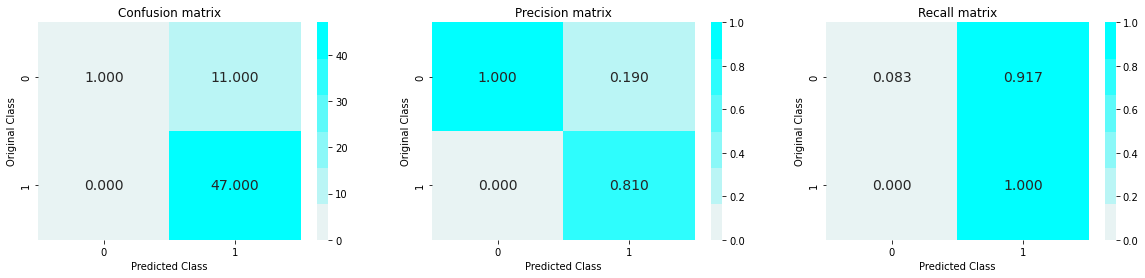

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score
0,Logistic Regression,0.532110,0.796610,0.796610,1.000000,0.886792
1,Decision Tree,0.784404,0.745763,0.807692,0.893617,0.848485
2,Random Forest,0.811927,0.813559,0.810345,1.000000,0.895238


In [28]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']

training_acc_list = []
testing_acc_list  = []
precision_list = []
recall_list    = []
f1_score_list  = []

for model_name in models:
    if model_name == 'Logistic Regression':
        print(model_name + ' intialized')
        clf =LogisticRegression()

    if model_name == 'Decision Tree':
        # create Decision Tree classifer object
        print(model_name + ' intialized')
        clf = DecisionTreeClassifier()
        
    if model_name == 'Random Forest':
        print(model_name + ' intialized')
        clf = RandomForestClassifier()
        
    print("Training model")
    # clf = clf.fit(X_smote,y_smote)
    clf = clf.fit(X_train, y_train)
    print("Completed model training.")
    
    print("Prediction on test")
    y_pred = clf.predict(X_test)
    
    
    train_accuracy = clf.score(X_smote, y_smote)
    training_acc_list.append(train_accuracy)
    
    test_accuracy  = clf.score(X_test, y_test)
    testing_acc_list.append(test_accuracy)
    
    prec_score     = precision_score(y_test, y_pred)
    precision_list.append(prec_score)
    
    rec_score      = recall_score(y_test, y_pred)
    recall_list.append(rec_score)
    
    f1_sc          = f1_score(y_test, y_pred)
    f1_score_list.append(f1_sc )
    
    
    
    print('Model: ', model_name)
    print("Classification_report")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)
    print("==============================================================================================================")
    print()
    print()
        
performance_df = pd.DataFrame()
performance_df['Model']                 = models
performance_df['Accuracy_Training_Set'] = training_acc_list
performance_df['Accuracy_Test_Set']     = testing_acc_list
performance_df['Precision']             = precision_list
performance_df['Recall']                = recall_list
performance_df['f1_score']              = f1_score_list
performance_df                

The ICU dataset that is highly imbalanced. It is important to consider which is the right metric to evaluate the models in terms of business context as well. If accuracy is chosen as a measure of performance, it will be very easy for the model to overfit on the majority class and get high accuracy.
In an imbalance dataset, it is important to check how well the model predict the minority class. The recall metrics can be used to observe the effectiveness of predicting minority class. The F1 score, the micro, and macro weighted average for performance measures can also be a good measure.
In this case, the size of the dataset is very small so there are very few samples for train and testing. It is difficult to directly jump to a good conclusion on which is the best model but based on the result, random forest algorithm tend to work better here.

## Hyper Parameter Tuning using Grid Search

Logistic Regression intialized

GridSearch optimal parametr:  {'C': 1, 'penalty': 'l2'}

Parameters search time:  2.9022223949432373
Training model
Completed model training.
Prediction on test
Model:  Logistic Regression
Classifcation_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        47

    accuracy                           0.80        59
   macro avg       0.40      0.50      0.44        59
weighted avg       0.63      0.80      0.71        59



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-27-2a838445d062>:7: RuntimeWarning: invalid value en

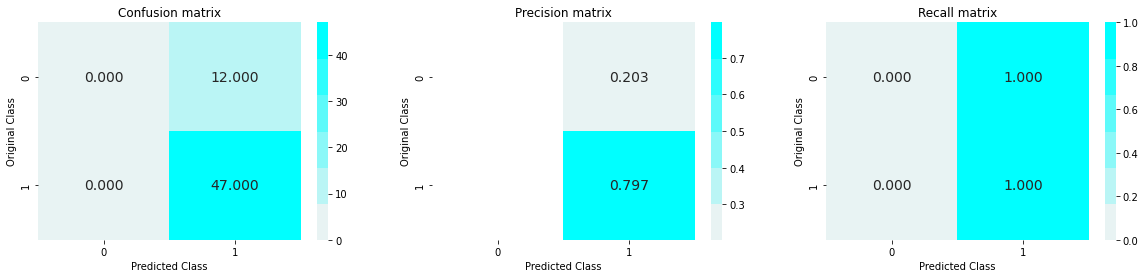



Decision Tree intialized

GridSearch optimal parameter:  {'max_depth': 2}

Parameter Search Time:  0.585716724395752
Training model
Completed model training.
Prediction on test
Model:  Decision Tree
Classifcation_report
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        12
           1       0.81      0.98      0.88        47

    accuracy                           0.80        59
   macro avg       0.65      0.53      0.51        59
weighted avg       0.74      0.80      0.73        59



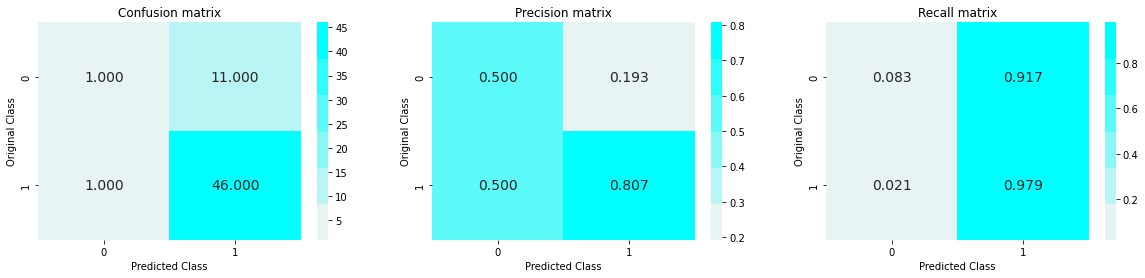



Random Forest intialized

GridSearch optimal parameter:  {'max_depth': 7, 'n_estimators': 500}
Gridsearch Time:  39.91006350517273

Training model
Completed model training.
Prediction on test
Model:  Random Forest
Classifcation_report
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.81      1.00      0.90        47

    accuracy                           0.81        59
   macro avg       0.91      0.54      0.52        59
weighted avg       0.85      0.81      0.74        59



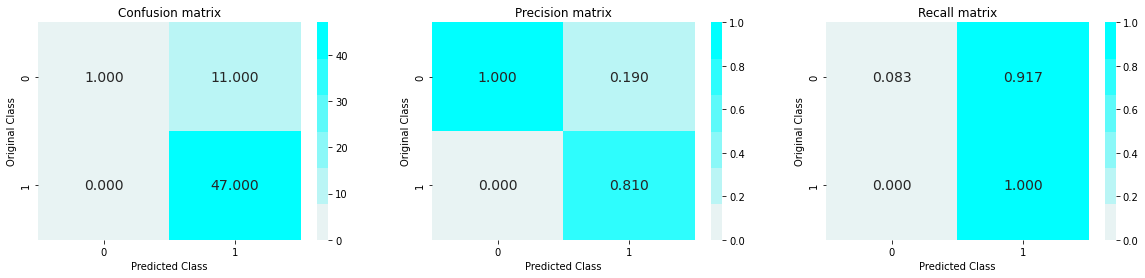

,Tuned Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score
0,Logistic Regression,0.532110,0.796610,0.796610,1.000000,0.886792
1,Decision Tree,0.582569,0.796610,0.807018,0.978723,0.884615
2,Random Forest,0.711009,0.813559,0.810345,1.000000,0.895238


In [29]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']

training_acc_list = []
testing_acc_list  = []
precision_list = []
recall_list    = []
f1_score_list  = []

for model_name in models:
    if model_name == 'Logistic Regression':
        print(model_name + ' intialized')
        
        start = time.time()
        log_rg = LogisticRegression(n_jobs=-1)
        grid_parameters = {'C':[10**-2, 10**-1, 1, 10],'penalty':['l2']}
        gridSearchModel = GridSearchCV(log_rg, grid_parameters, cv=10,n_jobs=-1)
        gridSearchModel.fit(X_smote, y_smote)
        print()
        print("GridSearch optimal parametr: ",gridSearchModel.best_params_)
        print()
        print('Parameters search time: ',(time.time() - start))
        
        clf = LogisticRegression(penalty=gridSearchModel.best_params_['penalty'], 
                                           C=gridSearchModel.best_params_['C'])

    if model_name == 'Decision Tree':
        # create Decision Tree classifer object
        print(model_name + ' intialized')
        
        start = time.time()
        dt = DecisionTreeClassifier()
        grid_parameters = {"max_depth": range(2,10), }
        grid_search = GridSearchCV(dt, grid_parameters, cv=10,scoring="neg_log_loss",n_jobs = -1)
        grid_result = grid_search.fit(X_smote, y_smote)
        print()
        print("GridSearch optimal parameter: ",grid_result.best_params_)
        print()
        print('Parameter Search Time: ',(time.time() - start))
        
        clf = DecisionTreeClassifier(max_depth = grid_result.best_params_['max_depth'])
        
        
        
    if model_name == 'Random Forest':
        print(model_name + ' intialized')
        
        start = time.time()
        clf= RandomForestClassifier(n_jobs=-1)
        grid_parameters = {"n_estimators": [150,300,500],'max_depth':[3,5,7]}
        grid_search = GridSearchCV(clf, grid_parameters, cv=10,n_jobs=-1)
        grid_result = grid_search.fit(X_smote, y_smote)
        print()
        print("GridSearch optimal parameter: ",grid_result.best_params_)
        print('Gridsearch Time: ',(time.time() - start))
        print()
        clf = RandomForestClassifier(n_estimators = grid_result.best_params_['n_estimators'],n_jobs=-1,max_depth = grid_result.best_params_['max_depth'])
        
    print("Training model")
    # clf = clf.fit(X_smote,y_smote)
    clf = clf.fit(X_train, y_train)
    print("Completed model training.")
    
    print("Prediction on test")
    y_pred = clf.predict(X_test)
    
    
    train_accuracy = clf.score(X_smote, y_smote)
    training_acc_list.append(train_accuracy)
    
    test_accuracy  = clf.score(X_test, y_test)
    testing_acc_list.append(test_accuracy)
    
    prec_score     = precision_score(y_test, y_pred)
    precision_list.append(prec_score)
    
    rec_score      = recall_score(y_test, y_pred)
    recall_list.append(rec_score)
    
    f1_sc          = f1_score(y_test, y_pred)
    f1_score_list.append(f1_sc )
    
    
    
    print('Model: ', model_name)
    print("Classifcation_report")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)
    print("============================================================================================================")
    print()
    print()
        
performance_df = pd.DataFrame()
performance_df['Tuned Model']                 = models
performance_df['Accuracy_Training_Set'] = training_acc_list
performance_df['Accuracy_Test_Set']     = testing_acc_list
performance_df['Precision']             = precision_list
performance_df['Recall']                = recall_list
performance_df['f1_score']              = f1_score_list
performance_df                

The ICU dataset that is highly imbalanced. It is important to consider which is the right metric to evaluate the models in terms of business context as well. If accuracy is chosen as a measure of performance, it will be very easy for the model to overfit on the majority class and get high accuracy.
In an imbalance dataset, it is important to check how well the model predict the minority class. The recall metrics can be used to observe the effectiveness of predicting minority class. The F1 score, the micro, and macro weighted average for performance measures can also be a good measure.
In this case, the size of the dataset is very small so there are very few samples for train and testing. It is difficult to directly jump to a good conclusion on which is the best model but based on the result, random forest algorithm tend to work better here, similar to observe baseline model results.